In [1]:
## Trim down imports to only neccesary 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from transformers import AutoFeatureExtractor, ViTForImageClassification, ViTModel
import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('default')
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.utils.data import Subset
from collections import namedtuple
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

import datasets_1 as datasets

import os
import datetime
import re




from simple_datasets import load_data
from sklearn.manifold import TSNE



/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still cha

In [2]:
## Pretrained model

class CustomViTEmbeddingModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomViTEmbeddingModel, self).__init__()
        
        # Extract the necessary layers from the original model
        self.embeddings = original_model.vit.embeddings  #.patch_embeddings
        self.encoder_layer_0 = original_model.vit.encoder.layer[0]
        self.encoder_layer_1 = original_model.vit.encoder.layer[1]
        
        # Assume a square grid of patches to reshape the sequence of patches back into a 2D grid
            ## image: 224x224 ; patch size: 16x16 --> 14x14 
        self.num_patches_side = 14

    def forward(self, x):
        # Apply the embeddings layer
        x = self.embeddings(x)
        
        # Pass the result through the first and second encoder layers
        x = self.encoder_layer_0(x)[0]  # [0] to get the hidden states
        x = self.encoder_layer_1(x)[0]  # [0] to get the hidden states
        
        # x is now the sequence of embeddings for the patches
            # The output x will be a sequence of embeddings, one for each patch of the input images.
            # If you're looking for a single vector representation per image, typically the class token embedding (the first token) is used. 
            # If the model doesn't use a class token, you might need to apply a different pooling strategy over the patch embeddings.
        
        ## Updating to reshape
        
        # Before reshaping, x is in shape [batch_size, num_patches+1, embedding_dim]
        # We discard the first token which is used for classification in the original ViT model
        x = x[:, 1:, :]  # Now in shape [batch_size, num_patches, embedding_dim]
        
        # Reshape to [batch_size, num_patches_side, num_patches_side, embedding_dim]
        x = x.reshape(-1, self.num_patches_side, self.num_patches_side, x.size(-1))

        # Permute to get [batch_size, embedding_dim, num_patches_side, num_patches_side]
        # This is a pseudo-spatial 2D grid, where embedding_dim becomes the channel dimension
        x = x.permute(0, 3, 1, 2)
        
        return x



In [16]:
## Adding in CNN component

## CNN for classification
class ClassificationCNN(nn.Module):
    def __init__(self, embedding_dim):
        super(ClassificationCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=embedding_dim, out_channels=256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.sig1 = nn.Sigmoid()

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.sig2 = nn.Sigmoid()
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.sig3 = nn.Sigmoid()
        
        self.dropout = nn.Dropout(p=0.1)
        self.adapt_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features=64, out_features=2)  # 2 for binary classification

    def forward(self, x, return_embedding=False):
        x = self.sig1(self.bn1(self.conv1(x)))
        x = self.sig2(self.bn2(self.conv2(x)))
        x = self.sig3(self.bn3(self.conv3(x)))
        if return_embedding:
            # Flatten the output from the convolutional layers
            x = torch.flatten(x, start_dim=1)
            return x
        x = self.dropout(x)
        x = self.adapt_pool(x)
        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [9]:
# Mapping dictionary
label_mapping = {'LVID': 0, 'SVID': 1}

# Function to convert labels to tensor
def labels_to_tensor(labels):
    # Map the labels to integers using label_mapping
    mapped_labels = [label_mapping[label] for label in labels]
    # Convert the list of integers to a tensor
    label_tensor = torch.tensor(mapped_labels, dtype=torch.long)
    return label_tensor

# Function to convert tensor back to labels
def tensor_to_labels(tensor):
    # Inverse mapping
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}
    # Convert the tensor of indices to labels
    labels = [inverse_label_mapping[int(index)] for index in tensor]
    return labels


/Users/willhoff/Desktop/research_23_24/research_09_11/env/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 1/100
Train Loss: 0.4907, Train Accuracy: 80.49%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 1/100
Train Loss: 0.4907, Train Accuracy: 80.49%
Val Loss: 0.2828, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 2/100
Train Loss: 0.3487, Train Accuracy: 91.22%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 2/100
Train Loss: 0.3487, Train Accuracy: 91.22%
Val Loss: 0.2019, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 3/100
Train Loss: 0.2799, Train Accuracy: 93.17%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 3/100
Train Loss: 0.2799, Train Accuracy: 93.17%
Val Loss: 0.1952, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 4/100
Train Loss: 0.3083, Train Accuracy: 90.24%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 4/100
Train Loss: 0.3083, Train Accuracy: 90.24%
Val Loss: 0.1515, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 5/100
Train Loss: 0.3050, Train Accuracy: 87.80%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 5/100
Train Loss: 0.3050, Train Accuracy: 87.80%
Val Loss: 0.2507, Val Accuracy: 92.31%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 6/100
Train Loss: 0.1948, Train Accuracy: 95.12%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 6/100
Train Loss: 0.1948, Train Accuracy: 95.12%
Val Loss: 0.1403, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 7/100
Train Loss: 0.2064, Train Accuracy: 95.61%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 7/100
Train Loss: 0.2064, Train Accuracy: 95.61%
Val Loss: 0.0940, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 8/100
Train Loss: 0.2341, Train Accuracy: 91.71%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 8/100
Train Loss: 0.2341, Train Accuracy: 91.71%
Val Loss: 0.6523, Val Accuracy: 53.85%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 9/100
Train Loss: 0.1930, Train Accuracy: 94.63%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 9/100
Train Loss: 0.1930, Train Accuracy: 94.63%
Val Loss: 0.2146, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 10/100
Train Loss: 0.1574, Train Accuracy: 93.66%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 10/100
Train Loss: 0.1574, Train Accuracy: 93.66%
Val Loss: 0.0920, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 11/100
Train Loss: 0.1746, Train Accuracy: 93.17%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 11/100
Train Loss: 0.1746, Train Accuracy: 93.17%
Val Loss: 0.1362, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 12/100
Train Loss: 0.1941, Train Accuracy: 92.68%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 12/100
Train Loss: 0.1941, Train Accuracy: 92.68%
Val Loss: 0.0520, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 13/100
Train Loss: 0.1272, Train Accuracy: 97.07%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 13/100
Train Loss: 0.1272, Train Accuracy: 97.07%
Val Loss: 0.0421, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 14/100
Train Loss: 0.1374, Train Accuracy: 96.59%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 14/100
Train Loss: 0.1374, Train Accuracy: 96.59%
Val Loss: 0.0522, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 15/100
Train Loss: 0.1855, Train Accuracy: 92.68%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 15/100
Train Loss: 0.1855, Train Accuracy: 92.68%
Val Loss: 0.0715, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 16/100
Train Loss: 0.1220, Train Accuracy: 96.59%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 16/100
Train Loss: 0.1220, Train Accuracy: 96.59%
Val Loss: 0.0942, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 17/100
Train Loss: 0.2020, Train Accuracy: 93.17%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 17/100
Train Loss: 0.2020, Train Accuracy: 93.17%
Val Loss: 0.0630, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 18/100
Train Loss: 0.1215, Train Accuracy: 97.07%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 18/100
Train Loss: 0.1215, Train Accuracy: 97.07%
Val Loss: 0.2208, Val Accuracy: 92.31%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 19/100
Train Loss: 0.1004, Train Accuracy: 97.56%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 19/100
Train Loss: 0.1004, Train Accuracy: 97.56%
Val Loss: 0.0348, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 20/100
Train Loss: 0.1142, Train Accuracy: 96.10%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 20/100
Train Loss: 0.1142, Train Accuracy: 96.10%
Val Loss: 0.0299, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 21/100
Train Loss: 0.1097, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 21/100
Train Loss: 0.1097, Train Accuracy: 98.05%
Val Loss: 0.0282, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 22/100
Train Loss: 0.0820, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 22/100
Train Loss: 0.0820, Train Accuracy: 98.05%
Val Loss: 0.0375, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 23/100
Train Loss: 0.0602, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 23/100
Train Loss: 0.0602, Train Accuracy: 98.05%
Val Loss: 0.0397, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 24/100
Train Loss: 0.1391, Train Accuracy: 93.66%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 24/100
Train Loss: 0.1391, Train Accuracy: 93.66%
Val Loss: 0.0513, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 25/100
Train Loss: 0.1893, Train Accuracy: 91.71%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 25/100
Train Loss: 0.1893, Train Accuracy: 91.71%
Val Loss: 0.0568, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 26/100
Train Loss: 0.1075, Train Accuracy: 96.59%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 26/100
Train Loss: 0.1075, Train Accuracy: 96.59%
Val Loss: 0.0197, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 27/100
Train Loss: 0.0922, Train Accuracy: 97.56%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 27/100
Train Loss: 0.0922, Train Accuracy: 97.56%
Val Loss: 0.0203, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 28/100
Train Loss: 0.1646, Train Accuracy: 93.66%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 28/100
Train Loss: 0.1646, Train Accuracy: 93.66%
Val Loss: 0.1183, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 29/100
Train Loss: 0.0932, Train Accuracy: 97.07%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 29/100
Train Loss: 0.0932, Train Accuracy: 97.07%
Val Loss: 0.0185, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 30/100
Train Loss: 0.0629, Train Accuracy: 98.54%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 30/100
Train Loss: 0.0629, Train Accuracy: 98.54%
Val Loss: 0.0206, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 31/100
Train Loss: 0.1251, Train Accuracy: 95.61%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 31/100
Train Loss: 0.1251, Train Accuracy: 95.61%
Val Loss: 0.0288, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 32/100
Train Loss: 0.1448, Train Accuracy: 94.63%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 32/100
Train Loss: 0.1448, Train Accuracy: 94.63%
Val Loss: 0.1478, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 33/100
Train Loss: 0.1132, Train Accuracy: 96.10%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 33/100
Train Loss: 0.1132, Train Accuracy: 96.10%
Val Loss: 0.0394, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 34/100
Train Loss: 0.1015, Train Accuracy: 95.61%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 34/100
Train Loss: 0.1015, Train Accuracy: 95.61%
Val Loss: 0.0202, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 35/100
Train Loss: 0.1690, Train Accuracy: 94.63%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 35/100
Train Loss: 0.1690, Train Accuracy: 94.63%
Val Loss: 0.0291, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 36/100
Train Loss: 0.1239, Train Accuracy: 96.10%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 36/100
Train Loss: 0.1239, Train Accuracy: 96.10%
Val Loss: 0.0239, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 37/100
Train Loss: 0.0824, Train Accuracy: 97.56%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 37/100
Train Loss: 0.0824, Train Accuracy: 97.56%
Val Loss: 0.0214, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 38/100
Train Loss: 0.1012, Train Accuracy: 97.07%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 38/100
Train Loss: 0.1012, Train Accuracy: 97.07%
Val Loss: 0.0152, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 39/100
Train Loss: 0.0987, Train Accuracy: 97.07%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 39/100
Train Loss: 0.0987, Train Accuracy: 97.07%
Val Loss: 0.1435, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 40/100
Train Loss: 0.0405, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 40/100
Train Loss: 0.0405, Train Accuracy: 100.00%
Val Loss: 0.1381, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 41/100
Train Loss: 0.1825, Train Accuracy: 90.73%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 41/100
Train Loss: 0.1825, Train Accuracy: 90.73%
Val Loss: 0.0308, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 42/100
Train Loss: 0.0384, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 42/100
Train Loss: 0.0384, Train Accuracy: 100.00%
Val Loss: 0.0114, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 43/100
Train Loss: 0.0386, Train Accuracy: 98.54%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 43/100
Train Loss: 0.0386, Train Accuracy: 98.54%
Val Loss: 0.0138, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 44/100
Train Loss: 0.0515, Train Accuracy: 99.02%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 44/100
Train Loss: 0.0515, Train Accuracy: 99.02%
Val Loss: 0.0204, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 45/100
Train Loss: 0.0833, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 45/100
Train Loss: 0.0833, Train Accuracy: 98.05%
Val Loss: 0.0160, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 46/100
Train Loss: 0.1323, Train Accuracy: 95.12%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 46/100
Train Loss: 0.1323, Train Accuracy: 95.12%
Val Loss: 0.0172, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 47/100
Train Loss: 0.0627, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 47/100
Train Loss: 0.0627, Train Accuracy: 98.05%
Val Loss: 0.0580, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 48/100
Train Loss: 0.0572, Train Accuracy: 98.54%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 48/100
Train Loss: 0.0572, Train Accuracy: 98.54%
Val Loss: 0.0342, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 49/100
Train Loss: 0.0658, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 49/100
Train Loss: 0.0658, Train Accuracy: 98.05%
Val Loss: 0.1877, Val Accuracy: 92.31%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 50/100
Train Loss: 0.0656, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 50/100
Train Loss: 0.0656, Train Accuracy: 98.05%
Val Loss: 0.0942, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 51/100
Train Loss: 0.0717, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 51/100
Train Loss: 0.0717, Train Accuracy: 98.05%
Val Loss: 0.0125, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 52/100
Train Loss: 0.0724, Train Accuracy: 97.56%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 52/100
Train Loss: 0.0724, Train Accuracy: 97.56%
Val Loss: 0.0498, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 53/100
Train Loss: 0.0978, Train Accuracy: 95.61%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 53/100
Train Loss: 0.0978, Train Accuracy: 95.61%
Val Loss: 0.0221, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 54/100
Train Loss: 0.0325, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 54/100
Train Loss: 0.0325, Train Accuracy: 100.00%
Val Loss: 0.0066, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 55/100
Train Loss: 0.0494, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 55/100
Train Loss: 0.0494, Train Accuracy: 98.05%
Val Loss: 0.0118, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 56/100
Train Loss: 0.0796, Train Accuracy: 96.59%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 56/100
Train Loss: 0.0796, Train Accuracy: 96.59%
Val Loss: 0.0213, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 57/100
Train Loss: 0.0953, Train Accuracy: 97.56%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 57/100
Train Loss: 0.0953, Train Accuracy: 97.56%
Val Loss: 0.0770, Val Accuracy: 96.15%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 58/100
Train Loss: 0.0311, Train Accuracy: 98.54%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 58/100
Train Loss: 0.0311, Train Accuracy: 98.54%
Val Loss: 0.0099, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 59/100
Train Loss: 0.0247, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 59/100
Train Loss: 0.0247, Train Accuracy: 100.00%
Val Loss: 0.0067, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 60/100
Train Loss: 0.0196, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 60/100
Train Loss: 0.0196, Train Accuracy: 100.00%
Val Loss: 0.0039, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 61/100
Train Loss: 0.0538, Train Accuracy: 98.54%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 61/100
Train Loss: 0.0538, Train Accuracy: 98.54%
Val Loss: 0.0475, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 62/100
Train Loss: 0.0845, Train Accuracy: 97.56%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 62/100
Train Loss: 0.0845, Train Accuracy: 97.56%
Val Loss: 0.0213, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 63/100
Train Loss: 0.0379, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 63/100
Train Loss: 0.0379, Train Accuracy: 100.00%
Val Loss: 0.0454, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 64/100
Train Loss: 0.0486, Train Accuracy: 99.02%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 64/100
Train Loss: 0.0486, Train Accuracy: 99.02%
Val Loss: 0.0099, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 65/100
Train Loss: 0.0394, Train Accuracy: 99.51%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 65/100
Train Loss: 0.0394, Train Accuracy: 99.51%
Val Loss: 0.0179, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 66/100
Train Loss: 0.0515, Train Accuracy: 98.54%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 66/100
Train Loss: 0.0515, Train Accuracy: 98.54%
Val Loss: 0.0157, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 67/100
Train Loss: 0.0836, Train Accuracy: 97.56%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 67/100
Train Loss: 0.0836, Train Accuracy: 97.56%
Val Loss: 0.0237, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 68/100
Train Loss: 0.0465, Train Accuracy: 99.51%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 68/100
Train Loss: 0.0465, Train Accuracy: 99.51%
Val Loss: 0.0090, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 69/100
Train Loss: 0.0436, Train Accuracy: 99.51%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 69/100
Train Loss: 0.0436, Train Accuracy: 99.51%
Val Loss: 0.0092, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 70/100
Train Loss: 0.0404, Train Accuracy: 99.02%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 70/100
Train Loss: 0.0404, Train Accuracy: 99.02%
Val Loss: 0.0079, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 71/100
Train Loss: 0.0353, Train Accuracy: 99.51%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 71/100
Train Loss: 0.0353, Train Accuracy: 99.51%
Val Loss: 0.0118, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 72/100
Train Loss: 0.0206, Train Accuracy: 99.51%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 72/100
Train Loss: 0.0206, Train Accuracy: 99.51%
Val Loss: 0.0063, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 73/100
Train Loss: 0.0363, Train Accuracy: 99.02%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 73/100
Train Loss: 0.0363, Train Accuracy: 99.02%
Val Loss: 0.0265, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 74/100
Train Loss: 0.0197, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 74/100
Train Loss: 0.0197, Train Accuracy: 100.00%
Val Loss: 0.0076, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 75/100
Train Loss: 0.0213, Train Accuracy: 99.51%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 75/100
Train Loss: 0.0213, Train Accuracy: 99.51%
Val Loss: 0.0224, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 76/100
Train Loss: 0.0385, Train Accuracy: 98.54%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 76/100
Train Loss: 0.0385, Train Accuracy: 98.54%
Val Loss: 0.0195, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 77/100
Train Loss: 0.0507, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 77/100
Train Loss: 0.0507, Train Accuracy: 100.00%
Val Loss: 0.0090, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 78/100
Train Loss: 0.0649, Train Accuracy: 98.05%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 78/100
Train Loss: 0.0649, Train Accuracy: 98.05%
Val Loss: 0.0227, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 79/100
Train Loss: 0.0270, Train Accuracy: 99.51%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 79/100
Train Loss: 0.0270, Train Accuracy: 99.51%
Val Loss: 0.0343, Val Accuracy: 98.08%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 80/100
Train Loss: 0.0163, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 80/100
Train Loss: 0.0163, Train Accuracy: 100.00%
Val Loss: 0.0107, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 81/100
Train Loss: 0.0179, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 81/100
Train Loss: 0.0179, Train Accuracy: 100.00%
Val Loss: 0.0041, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 82/100
Train Loss: 0.0157, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 82/100
Train Loss: 0.0157, Train Accuracy: 100.00%
Val Loss: 0.0051, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 83/100
Train Loss: 0.0149, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 83/100
Train Loss: 0.0149, Train Accuracy: 100.00%
Val Loss: 0.0108, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 84/100
Train Loss: 0.0172, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 84/100
Train Loss: 0.0172, Train Accuracy: 100.00%
Val Loss: 0.0064, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 85/100
Train Loss: 0.0253, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 85/100
Train Loss: 0.0253, Train Accuracy: 100.00%
Val Loss: 0.0053, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 86/100
Train Loss: 0.0457, Train Accuracy: 99.02%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 86/100
Train Loss: 0.0457, Train Accuracy: 99.02%
Val Loss: 0.0089, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 87/100
Train Loss: 0.0316, Train Accuracy: 99.02%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 87/100
Train Loss: 0.0316, Train Accuracy: 99.02%
Val Loss: 0.0264, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 88/100
Train Loss: 0.0157, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 88/100
Train Loss: 0.0157, Train Accuracy: 100.00%
Val Loss: 0.0029, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 89/100
Train Loss: 0.0087, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 89/100
Train Loss: 0.0087, Train Accuracy: 100.00%
Val Loss: 0.0034, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 90/100
Train Loss: 0.0123, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 90/100
Train Loss: 0.0123, Train Accuracy: 100.00%
Val Loss: 0.0030, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 91/100
Train Loss: 0.0105, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 91/100
Train Loss: 0.0105, Train Accuracy: 100.00%
Val Loss: 0.0032, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 92/100
Train Loss: 0.0146, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 92/100
Train Loss: 0.0146, Train Accuracy: 100.00%
Val Loss: 0.0047, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 93/100
Train Loss: 0.0160, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 93/100
Train Loss: 0.0160, Train Accuracy: 100.00%
Val Loss: 0.0072, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 94/100
Train Loss: 0.0064, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 94/100
Train Loss: 0.0064, Train Accuracy: 100.00%
Val Loss: 0.0032, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 95/100
Train Loss: 0.0258, Train Accuracy: 99.51%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 95/100
Train Loss: 0.0258, Train Accuracy: 99.51%
Val Loss: 0.0226, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 96/100
Train Loss: 0.0064, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 96/100
Train Loss: 0.0064, Train Accuracy: 100.00%
Val Loss: 0.0041, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 97/100
Train Loss: 0.0039, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 97/100
Train Loss: 0.0039, Train Accuracy: 100.00%
Val Loss: 0.0017, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 98/100
Train Loss: 0.0131, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 98/100
Train Loss: 0.0131, Train Accuracy: 100.00%
Val Loss: 0.0033, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 99/100
Train Loss: 0.0122, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 99/100
Train Loss: 0.0122, Train Accuracy: 100.00%
Val Loss: 0.0035, Val Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 100/100
Train Loss: 0.0073, Train Accuracy: 100.00%


ClassificationCNN(
  (conv1): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig1): Sigmoid()
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig2): Sigmoid()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sig3): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (adapt_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Epoch 100/100
Train Loss: 0.0073, Train Accuracy: 100.00%
Val Loss: 0.0040, Val Accuracy: 100.00%


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss Over Epochs')

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Accuracy Over Epochs')

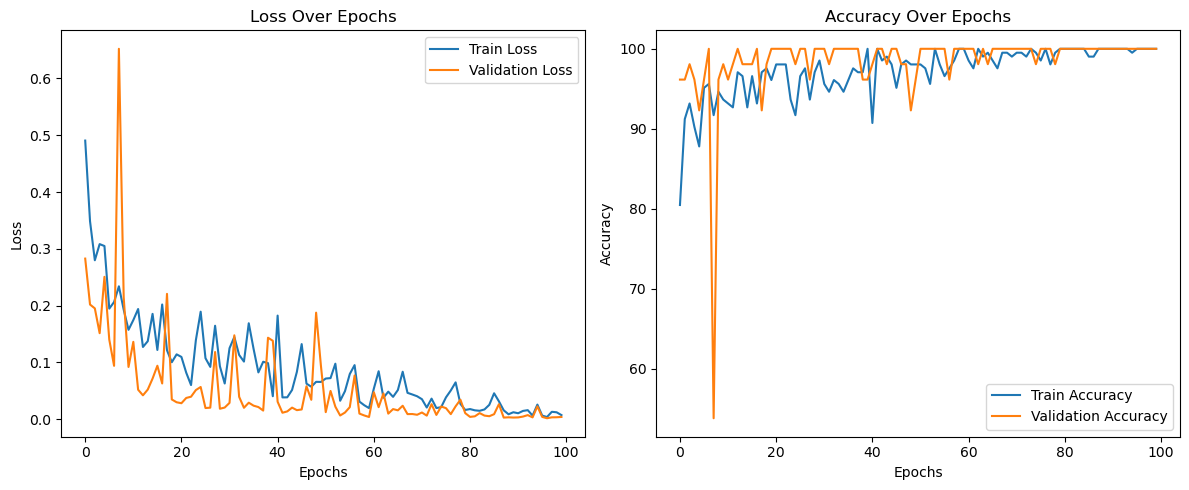

In [19]:
############################################ ############################################ ############################################ 
############################################ ############################################ ############################################ 
###############################################       TRAINING          ############################################ 
############################################ ############################################ ############################################ 
############################################ ############################################ ############################################ 


# Training loop
num_epochs = 100
## Started w 0.001, went up to 0.01
lr = 0.001

# Instantiate the model
cnn_model = ClassificationCNN(embedding_dim=192)

# Load the pre-trained ViT model
pretrained_vit = ViTForImageClassification.from_pretrained('facebook/deit-tiny-patch16-224')

## Freeze params
for param in pretrained_vit.parameters():
    param.requires_grad = False

# Create model w first three layers and create embedding
custom_model = CustomViTEmbeddingModel(pretrained_vit)

# Define a Loss Function and Optimizer for classification
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=lr)

train_loader, test_loader, _ = load_data("%TOC", lake="both", set="full", scaled=False)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    cnn_model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        optimizer.zero_grad()
        images, _, batch_depths, batch_source = batch
        batch_source_tensor = labels_to_tensor(batch_source)
        embeddings = custom_model(images)  # Get embeddings from the ViT
        outputs = cnn_model(embeddings)  # Pass embeddings to the CNN
        loss = loss_function(outputs, batch_source_tensor)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_source_tensor.size(0)
        correct += (predicted == batch_source_tensor).sum().item()
    
    # Calculate training accuracy and loss
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Print out the metrics
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')

    
    # Validation step
    cnn_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            images, _, batch_depths, batch_source = batch
            embeddings = custom_model(images)
            outputs = cnn_model(embeddings)
            batch_source_tensor = labels_to_tensor(batch_source)
            loss = loss_function(outputs, batch_source_tensor)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_source_tensor.size(0)
            correct += (predicted == batch_source_tensor).sum().item()
    
    # Calculate validation accuracy and loss
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)

    # Print out the metrics for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss / len(test_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(12, 5))

# Left plot for loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Right plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()

timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
save_dir = 't-SNE'

# Saving the plot
# Ensure the target directory exists
os.makedirs(save_dir, exist_ok=True)
filename = f'%TOC_plot_{timestamp}.png'

plt.savefig(os.path.join(save_dir, filename))

plt.show()

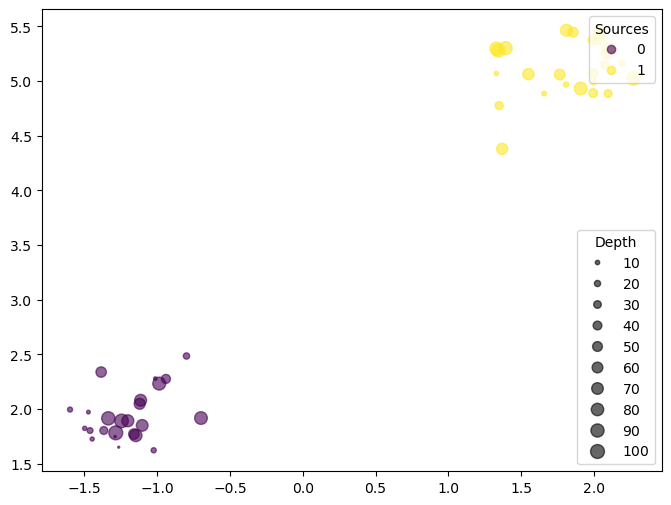

In [18]:
### T-SNE Demo starts here

def get_embeddings(model, test_loader):
    model.eval()
    all_embeddings = []
    all_depths = []
    all_sources = []
    with torch.no_grad():
        for images, _, depths, sources in test_loader:
            vit_embeddings = custom_model(images)  # Get embeddings from the ViT
            embeddings = model(vit_embeddings, return_embedding=True)
            embeddings = embeddings.reshape(embeddings.size(0), -1)
            all_embeddings.append(embeddings)
            all_depths.extend(depths)
            all_sources.extend(sources)
    
     # Concatenate all embeddings into a single 2D array
    all_embeddings_np = np.concatenate(all_embeddings, axis=0)
    
    # Apply t-SNE transformation
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings_np)
    
    return embeddings_2d, all_depths, all_sources

def plot_tsne(embeddings_2d, depths, sources):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate max and min depths for each lake
    max_depths = {}
    min_depths = {}
    for source in set(sources):
        source_mask = [s == source for s in sources]
        max_depths[source] = max([d for d, m in zip(depths, source_mask) if m])
        min_depths[source] = min([d for d, m in zip(depths, source_mask) if m])
    
    # Normalize depths differently based on source
    normalized_depths = [
        100 * (depth - min_depths[source]) / (max_depths[source] - min_depths[source])
        for depth, source in zip(depths, sources)
    ]
    
    # Convert sources to numeric values for coloring
    unique_sources = list(set(sources))
    source_colors = {source: i for i, source in enumerate(unique_sources)}
    colors = [source_colors[source] for source in sources]

    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=normalized_depths, cmap='viridis', alpha=0.6)
    
    # Create a legend for sources
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Sources")
    ax.add_artist(legend1)
    
    # Create a legend for sizes (depths)
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    legend2 = ax.legend(handles, labels, loc="lower right", title="Depth")
    
    timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")
    save_dir = 't-SNE'

    # Saving the plot
    # Ensure the target directory exists
    os.makedirs(save_dir, exist_ok=True)
    filename = f't-SNE_{timestamp}2.png'

    plt.savefig(os.path.join(save_dir, filename))
    plt.show()

# Get the embeddings, depths, and sources
embeddings_2d, depths, sources = get_embeddings(cnn_model, test_loader)

# Plot the t-SNE visualization
plot_tsne(embeddings_2d, depths, sources)
